
# Extract text

**Imports**

In [1]:
import re
import json
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from pdfminer.layout import LAParams
import numpy as np
import networkx as nx
import pandas as pd
import locale
import tabula
import pdfplumber
from wordcloud import WordCloud
import plotly.express as px
import nltk
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
from pdfminer.high_level import extract_text
def extract_text_from_pdf(pdf_path):
    laparams = LAParams()
    text = extract_text(pdf_path,laparams)
    return text.split("\f")

In [3]:
extract_text_from_pdf('CanadianTire.pdf')

['Canadian Tire Corporation Reports Third Quarter 2024 Results; Announces Annual \n\nDividend Increase for 15th Consecutive Year and Share Repurchase Intention \n\nToronto, November 7, 2024 – Canadian Tire Corporation, Limited (TSX:CTC, TSX: CTC.A) (CTC \nor the Company) today released its third quarter results for the period ended September 28, 2024.  \n\n•  Consolidated  comparable  sales1  trend  improved  compared  to  Q2  2024;  consolidated \n\ncomparable sales were down 1.5% compared to Q3 2023.  \n\n•  Diluted and Normalized Earnings Per Share1 (EPS) were $3.59, compared to $(1.19) in Q3 \n\n2023, and up 21.3% from $2.96 on a normalized basis. \n\n•  Annualized  dividend  increased  from  $7.00  to  $7.10  per  share,  alongside  an  intention  to \n\nrepurchase up to $200.0 million of Class A Non-Voting Shares in 2025.  \n\n“We delivered strong retail profitability for the third consecutive quarter and sales trends improved,” \n\nsaid  Greg  Hicks,  President  and  CEO,  Canad

## Extract text across pages

In [4]:

def normalize_text(text):
    return re.sub(r'\s+', ' ', text.strip()).lower()

def extract_text_between_words_across_pages(text_pages, start_word, end_word):
    # Normalize words
    start_word = normalize_text(start_word)
    end_word = normalize_text(end_word)
    extracted_texts = []
    combined_text = "\n".join([normalize_text(page) for page in text_pages])
    pattern = re.compile(re.escape(start_word) + '(.*?)' + re.escape(end_word), re.S)

    for match in pattern.finditer(combined_text):
        start_page, end_page = None, None
        start_index, end_index = match.start(), match.end()

        cumulative_length = 0
        for i, page in enumerate(text_pages):
            page_length = len(page)
            if start_page is None and start_index < cumulative_length + page_length:
                start_page = i + 1
            if end_page is None and end_index <= cumulative_length + page_length:
                end_page = i + 1
            cumulative_length += page_length + len("\n")
            if start_page is not None and end_page is not None:
                break

        extracted_texts.append({
            'start_page': start_page,
            'end_page': end_page,
            'start_word': start_word,
            'end_word': end_word,
            'extracted_text': match.group(1).strip()
        })
    return extracted_texts


Extract text by sections

In [5]:
start_end_pairs = [
    ('THIRD-QUARTER HIGHLIGHTS', 'products are set to roll out during 2025.'),
    ('CONSOLIDATED OVERVIEW','Company in the quarter.'),
    ('RETAIL SEGMENT OVERVIEW','impacted the Retail segment in the quarter.'),
    ('FINANCIAL SERVICES OVERVIEW','Services segment in the quarter.'),
    ('CT REIT OVERVIEW','November 5, 2024.'),
    ('CAPITAL ALLOCATION','million to $575 million.'),
    ('QUARTERLY DIVIDEND','for tax purposes.'),
    ('SHARE REPURCHASES','to regulatory approvals.'),
    ('1) NON-GAAP FINANCIAL MEASURES','Owned brand penetration'),
    ('FORWARD-LOOKING STATEMENTS', 'by applicable securities laws.'),
    ('CONFERENCE CALL','at this website for 12 months.'),
    ('ABOUT CANADIAN TIRE CORPORATION','visit Corp.CanadianTire.ca.'),
    ('FOR MORE INFORMATION','karen.keyes@cantire.com')
    # Add more pairs as needed
]


def process_files_in_folder(file_name, start_end_pairs):
    all_extracted_texts = []
    if file_name.endswith('.pdf'):
      text_pages = extract_text_from_pdf(file_name)
      for start_word, end_word in start_end_pairs:
        extracted_texts = extract_text_between_words_across_pages(text_pages, start_word, end_word)
        all_extracted_texts.extend(extracted_texts)

    return all_extracted_texts

all_extracted_texts = process_files_in_folder('CanadianTire.pdf', start_end_pairs)

## Cleansing/Preprocessing 

In [6]:
# Improved text normalization and cleaning
def advanced_preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Expand common contractions (e.g., "isn't" -> "is not")
    contractions_dict = {
        "isn't": "is not", "aren't": "are not", "can't": "cannot",
        "won't": "will not", "n't": " not", "'re": " are",
        "'s": " is", "'d": " would", "'ll": " will", "'t": " not",
        "'ve": " have", "'m": " am"
    }
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())))
    text = contractions_pattern.sub(lambda x: contractions_dict[x.group()], text)

    # Remove bullet points and special characters
    text = re.sub(r'[\u2022]', '', text)  # Remove specific bullet character
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove remaining non-alphanumeric characters
    
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Text summarizer
Summarize text by section
Lets Create a text summarizer using Cosine Distance

In [7]:
def generate_summary(article, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text and split it into sentences
    sentences = [sent_tokenize(article)]
    sentences = [sent for sublist in sentences for sent in sublist]  # Flatten list of lists

    # Step 2 - Tokenize sentences for similarity calculation
    tokenized_sentences = [word_tokenize(sent) for sent in sentences]

    # Step 3 - Generate Similarity Matrix across sentences
    sentence_similarity_matrix = build_similarity_matrix(tokenized_sentences, stop_words)

    # Step 4 - Rank sentences in similarity matrix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 5 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    print("Indexes of top ranked_sentence order are ", ranked_sentence)
    
    for i in range(min(top_n, len(ranked_sentence))):
        summarize_text.append(ranked_sentence[i][1])

    # Return the summarized text
    print("Summarized Text: \n", ". ".join(summarize_text))
    return ". ".join(summarize_text)



# Function to build similarity matrix
def build_similarity_matrix(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:  # Ignore same sentences
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix

# Function to compute sentence similarity
def sentence_similarity(sent1, sent2, stop_words=None):
    if stop_words is None:
        stop_words = []
    sent1 = [w.lower() for w in sent1 if w not in stop_words]
    sent2 = [w.lower() for w in sent2 if w not in stop_words]

    all_words = list(set(sent1 + sent2))
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    for w in sent1:
        vector1[all_words.index(w)] += 1
    for w in sent2:
        vector2[all_words.index(w)] += 1

    return 1 - cosine_distance(vector1, vector2)



## Saving and Structuring

In [8]:
def process_and_summarize_sections(extracted_sections, preprocess_func, summary_func, top_n_summary=1):
    processed_data = {
        'document_sections': []
    }

    for section in extracted_sections:
        
        # Preprocess the full text
        preprocessed_text = preprocess_func(section['extracted_text'])
        print(f"Summary for section starting with '{section['start_word']}' and ending with '{section['end_word']}':")
        # Generate summary
        summary = summary_func(preprocessed_text, top_n=top_n_summary)

        # Append to processed data
        processed_data['document_sections'].append({
            'start_word': section['start_word'],
            'end_word': section['end_word'],
            'preprocessed_text': preprocessed_text,
            'summary': summary,
            'full_text': section['extracted_text']
        })
    # Save the processed data to a JSON file
    with open('processed_document.json', 'w') as file:
        json.dump(processed_data, file, indent=4)

    return processed_data


In [9]:
processed_data = process_and_summarize_sections(all_extracted_texts, advanced_preprocess_text, generate_summary, top_n_summary=1)

Summary for section starting with 'third-quarter highlights' and ending with 'products are set to roll out during 2025.':
Indexes of top ranked_sentence order are  [(1.0, 'consolidated comparable sale 15 sportchek grew first quarter since q2 2023 partially offset decline canadian tire retail ctr mark ctr comparable sales1 22 compared q3 2023 customer continued prioritize essential category including automotive continued perform well strong quarter q3 2023 led growth automotive service sportchek comparable sales1 29 marking two consecutive quarter sportchek outperformed industry trend targeted promotional event improved customer experience continued focus contributed growth athletic footwear hockey category mark comparable sales1 23 led industrial wear decline partially offset growth men short tshirts childrens wear top performer result ongoing strategic rollout category select mark store increased loyalty engagement saw active registered loyalty member 4 member took advantage 11 offer 

# Visualisations 

In [10]:
import json
processed_data_string = json.dumps(processed_data, indent=4)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Uma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Uma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


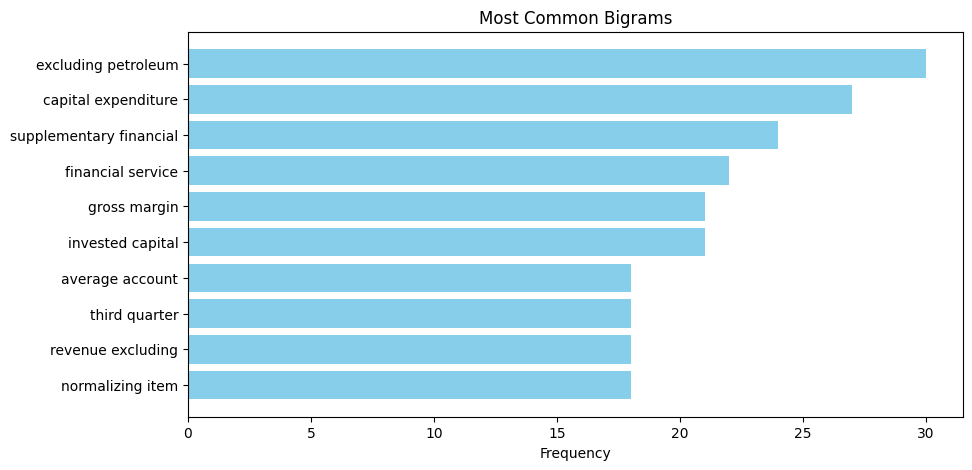

In [11]:
import nltk
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

# Defining stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'million', 'retail', 'segment', 'normalized', 'consolidated',
    'asset', 'measure', 'investment', 'taxes', 'information','following','table','reconciles','ytd',
    'company', 'sale', 'customer', 'sales1', 'section', 'year', 'canadian',
       'income', 'q3', '2024', 'tax', '2023', 'ct', 'reit','could','cause','actual','c','le','operating'

}
stop_words.update(custom_stopwords)

# Preprocessing the text by removing stopwords
def preprocess_func(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Remove stopwords
    return filtered_tokens

# Generating bigrams and trigrams from the tokens
def generate_ngrams(tokens, n=2):
    return list(ngrams(tokens, n))

processed_tokens = preprocess_func(processed_data_string)


bigrams = generate_ngrams(processed_tokens, n=2)
trigrams = generate_ngrams(processed_tokens, n=3)

# Counting the frequency of bigrams and trigrams
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)


# Plotting bar chart for n-grams
def plot_ngram_counts(ngram_counts, title):
    common_ngram_counts = ngram_counts.most_common(10)  # Top 10 n-grams
    labels, values = zip(*common_ngram_counts)
    
    
    labels = [' '.join(label) for label in labels]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, values, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()  # To show the most frequent n-grams on top
    plt.show()


# Plot bar charts for the most common bigrams and trigrams
plot_ngram_counts(bigram_counts, "Most Common Bigrams")



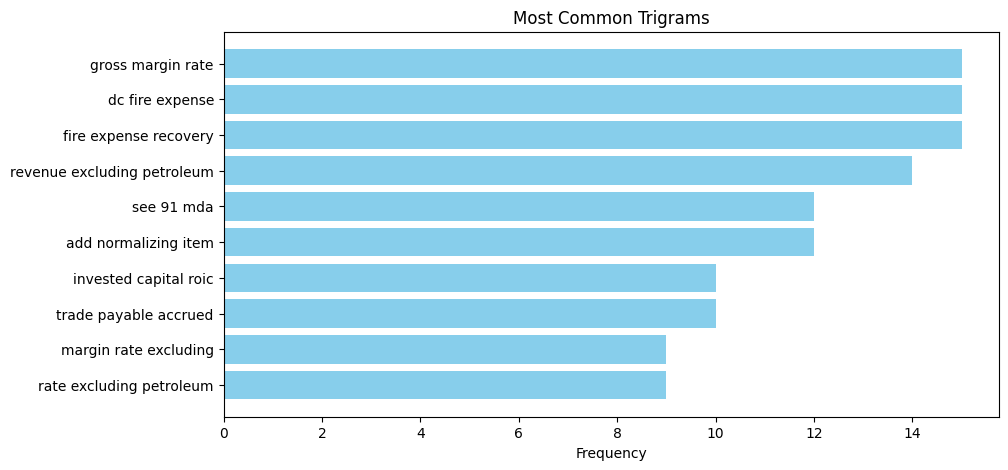

In [12]:
plot_ngram_counts(trigram_counts, "Most Common Trigrams")

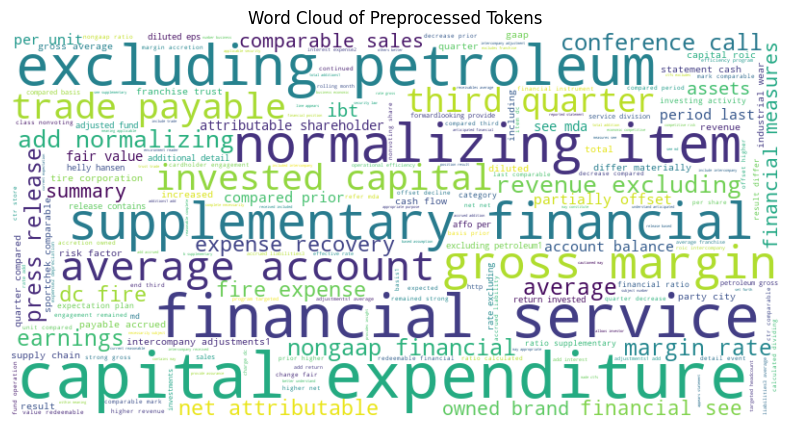

In [13]:
# Generate a word cloud from processed tokens
def generate_word_cloud(tokens, title):
    # Join tokens back into a single string for word cloud generation
    text = ' '.join(tokens)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stop_words,  # Use the stopwords defined earlier
        colormap='viridis'
    ).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate and plot word cloud
generate_word_cloud(processed_tokens, "Word Cloud of Preprocessed Tokens")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Uma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


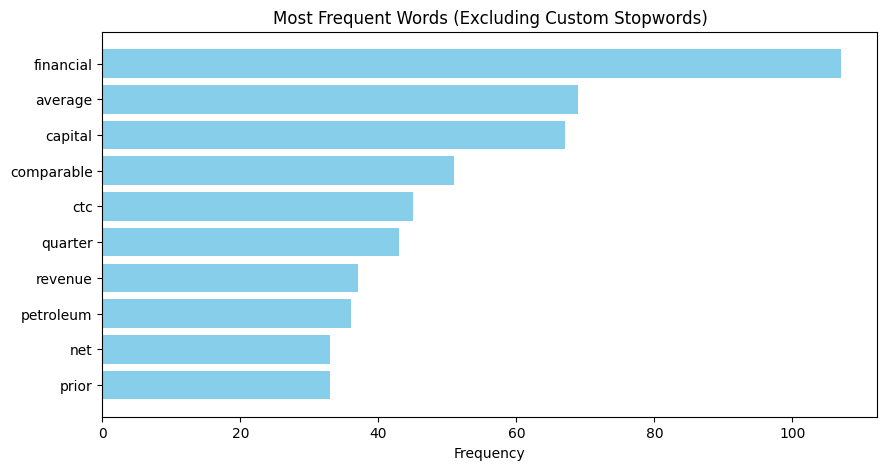

Most Frequent Words:
financial: 107
average: 69
capital: 67
comparable: 51
ctc: 45
quarter: 43
revenue: 37
petroleum: 36
net: 33
prior: 33


In [14]:
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')

# Define default and custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'million', 'retail', 'segment', 'normalized', 'consolidated',
    'asset', 'measure', 'investment', 'taxes', 'information', 'following', 'table', 
    'reconciles', 'ytd', 'company', 'sale', 'customer', 'sales1', 'section', 
    'year', 'canadian', 'income', 'q3', '2024', 'tax', '2023', 'ct', 'reit', 
    'could', 'cause', 'actual', 'c', 'le', 'operating','compared','excluding','add','tire'
}
stop_words.update(custom_stopwords)



# Function to count and display the most frequent words
def display_most_frequent_words(tokens, top_n=10):
    # Count word frequencies
    # Function to preprocess the text by removing stopwords

    tokens = nltk.word_tokenize(processed_data_string.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Remove stopwords
    word_counts = Counter(filtered_tokens)
    
    # Get the top N most frequent words
    most_common_words = word_counts.most_common(top_n)
    
    # Separate words and their frequencies for plotting
    words, counts = zip(*most_common_words)
    
    # Plot the most frequent words
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title('Most Frequent Words (Excluding Custom Stopwords)')
    plt.gca().invert_yaxis()  # To show the most frequent words on top
    plt.show()

    # Print the most frequent words for reference
    print("Most Frequent Words:")
    for word, count in most_common_words:
        print(f"{word}: {count}")



# Display the most frequent words
display_most_frequent_words(processed_tokens, top_n=10)


# Scrapping tables

Tables on pages: 6,7,8,9 and 10 (3 tables on page 7)

In [15]:
# Function to set locale safely
def set_locale(locale_name):
    try:
        locale.setlocale(locale.LC_ALL, locale_name)
    except locale.Error:
        print(f"Locale {locale_name} not supported on this system. Using default locale.")
        locale.setlocale(locale.LC_ALL, '')

# Set the locale (adjust as necessary for your system)
set_locale('en_US.UTF-8')  # Common locale setting for Unix-like systems
locale._override_localeconv = {'n_sign_posn':1}

In [16]:
# Format as currency
def format_currency(value):
    if pd.isna(value):
        return ''
    return locale.currency(value, grouping=True).split('.')[0]

## Extract tables

In [17]:
# Path to the PDF file
pdf_path = 'CanadianTire.pdf'
table = tabula.read_pdf(pdf_path, pages=[6,7,8,9,10], multiple_tables=True)

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


## Separate and organize them

Tables on pages: 6,7,8,9 and 10 (3 tables on page 7)

### Table 1 - Page 6

In [18]:
table1 = table[0]
table1

,Net income,$,220.7 $,(27.8) $,540.2 $,141.9
0,Net income attributable to shareholders,NaN,200.6,(66.4),476.2,40.8
1,Add normalizing items:,NaN,NaN,NaN,NaN,NaN
2,DC fire expense (recovery),$,— $,(96.4) $,— $,8.4
3,GST/HST-related charge1,NaN,—,—,—,24.7
4,Change in fair value of redeemable financial i...,NaN,—,328.0,—,328.0
5,Normalized Net income,$,220.7 $,203.8 $,540.2 $,503.0
6,Normalized Net income attributable to sharehol...,$,200.6 $,165.2 $,476.2 $,396.9
7,Normalized Diluted EPS,$,3.59 $,2.96 $,8.54 $,7.0


we drop the extra column

In [19]:
table1.drop(columns='$', inplace=True)

All of the tables are omiting the column names and instead are using the first row as such. For this we create a function to add the names of the columns and use the first column as the index

In [20]:
def structure_table(table, new_columns):
    # Step 1: Move the current header to the first row
    table = table.rename(columns={i: col for i, col in enumerate(table.iloc[0])})
    table.loc[-1] = list(table.columns)  # Insert the header row as the first row
    table.index = table.index + 1       # Adjust the index
    table = table.sort_index()          # Re-sort by index

    # Step 2: Rename the columns
    table.columns = new_columns
    
    return table

In [21]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table1 = structure_table(table1, new_columns)
print("\nModified DataFrame:")
table1


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Net income,220.7 $,(27.8) $,540.2 $,141.9
1,Net income attributable to shareholders,200.6,(66.4),476.2,40.8
2,Add normalizing items:,NaN,NaN,NaN,NaN
3,DC fire expense (recovery),— $,(96.4) $,— $,8.4
4,GST/HST-related charge1,—,—,—,24.7
5,Change in fair value of redeemable financial i...,—,328.0,—,328.0
6,Normalized Net income,220.7 $,203.8 $,540.2 $,503.0
7,Normalized Net income attributable to sharehol...,200.6 $,165.2 $,476.2 $,396.9
8,Normalized Diluted EPS,3.59 $,2.96 $,8.54 $,7.0


In [22]:
def numeric_conversion(table1, columns=None):

    # select everything except first column 
    if columns is None:
        columns = table1.select_dtypes(include=['object']).columns[1:]

    for col in columns:
        # Removing non-numeric characters and handle invalid values
        table1[col] = (
            table1[col]
            .astype(str)  
            .str.replace(r'[^\d.-]', '', regex=True)  # Removing non-numeric characters except '-' and '.'
            .replace(['', '-', 'NaN'], np.nan)  # Replacing invalid values with NaN
            .astype(float)  # Converting to float
        )
    
    return table1
table1=numeric_conversion(table1)

In [56]:
def barplots(table1, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table1.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="Normalized Diluted Earnings per Share Distribution",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table1)


A net income for Q3-2024 has been more than that of Q3-2023. YTD net income for Q3 2024 also seems higher than that for Q3 2023 YTD. Normalizing items appears to add positively to net income in Q3 2024, and in YTD Q3 2024, the effect is little.
DC Fire Expense (Recovery) has a negative effect on net income in Q3 2023. The effect is insignificant, both in Q3 2024 and YTD Q3 2024. GST/HST Related Charge is a negative impact category on net income for Q3 2024. Less so, indeed, for YTD Q3 2024.
Change in Fair Value of Redeemable Financial Instrument the impact is seen in UDS Q3 2024, in favor of net income-generating. However, the effect is less for YTD Q3 2024.Normalized Net Income Q3 2024 surpassed the normalized net income coincidence math Q3 2023. The trend has been preserved for YTD Q3 as well.Normalized diluted EPS for Q3 2024 is greater than that for Q3 2023. The same trends are consistent for YTD Q3.

So overall, the report indicates a positive performance by Canadian Tire for Q3 2024 over Q3 2023. The company seems to have increased both net income and earnings per share despite some negatives such as the GST/HST charge and the DC fire expense.

## Table 2-4: Page 7

Tabula is not detecting the first table of the page 7, so it will be extracted using a different method

## First table

In [24]:
# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:

    page = pdf.pages[6] #BMO Report has table on Page 4

    text = page.extract_text()

print(text)

lines = text.split('\n')

data = []
headers = None

for line in lines:
    columns = line.split()

    if '(C$ in millions)' in line:
        headers = columns
    elif any(char.isdigit() for char in line.split()[0]):
        data.append(columns)

The following table reconciles Consolidated Normalized Income Before Income Taxes to Income
Before Income Taxes:
YTD YTD
(C$ in millions) Q3 2024 Q3 2023 Q3 2024 Q3 2023
Income before income taxes $ 299.3 $ 69.3 $ 716.9 $ 309.8
Add normalizing items:
DC fire expense (recovery) — (131.0) — 11.3
GST/HST-related charge — — — 33.3
Change in fair value of redeemable financial instrument — 328.0 328.0
Normalized Income before income taxes $ 299.3 $ 266.3 $ 716.9 $ 682.4
The following table reconciles Retail Normalized Income Before Income Taxes to Income Before
Income Taxes:
YTD YTD
(C$ in millions) Q3 2024 Q3 2023 Q3 2024 Q3 2023
Income before income taxes $ 299.3 $ 69.3 $ 716.9 $ 309.8
Less: Other operating segments 134.5 (169.7) 381.4 64.5
Retail Income before income taxes $ 164.8 $ 239.0 $ 335.5 $ 245.3
Add normalizing items:
DC fire expense (recovery) — (131.0) — 11.3
Retail Normalized Income before income taxes $ 164.8 $ 108.0 $ 335.5 $ 256.6
The following table reconciles Financial Se

In [25]:
print(lines[3:10])
text = lines[3:10]

['(C$ in millions) Q3 2024 Q3 2023 Q3 2024 Q3 2023', 'Income before income taxes $ 299.3 $ 69.3 $ 716.9 $ 309.8', 'Add normalizing items:', 'DC fire expense (recovery) — (131.0) — 11.3', 'GST/HST-related charge — — — 33.3', 'Change in fair value of redeemable financial instrument — 328.0 328.0', 'Normalized Income before income taxes $ 299.3 $ 266.3 $ 716.9 $ 682.4']


In [26]:
table_data = []
# Regex to extract the description and four dollar values or placeholders
pattern = r"^(.*?)(?:\s+\$?\s*(-?[\d.]+|—)\s+\$?\s*(-?[\d.]+|—)\s+\$?\s*(-?[\d.]+|—)\s+\$?\s*(-?[\d.]+|—))?$"

# Process each line in the text
for line in text[1:]:  # Skip the first line (header)
    match = re.match(pattern, line)
    if match:
        description = match.group(1).strip()  # Extract description
        values = [match.group(i).strip() if match.group(i) else "-" for i in range(2, 6)]  # Extract values
        table_data.append([description] + values)

# Create a DataFrame with appropriate column names
table2 = pd.DataFrame(table_data, columns=new_columns)
table2

,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3,69.3,716.9,309.8
1,Add normalizing items:,-,-,-,-
2,DC fire expense (recovery) — (131.0) — 11.3,-,-,-,-
3,GST/HST-related charge,—,—,—,33.3
4,Change in fair value of redeemable financial i...,-,-,-,-
5,Normalized Income before income taxes,299.3,266.3,716.9,682.4


In [27]:
# Let's manually update the specific row 2
row_index = 2

# Manually split the data and assign values
table2.at[row_index, '(C$ in millions)'] = 'DC fire expense (recovery)'
table2.at[row_index, 'Q3_2024'] = '-'
table2.at[row_index, 'Q3_2023'] = '(131.0)'
table2.at[row_index, 'YTD_Q3_2024'] = '-'
table2.at[row_index, 'YTD_Q3_2023'] = '11.3'

# Let's manually update the specific row 2
row_index = 4

# Manually split the data and assign values
table2.at[row_index, '(C$ in millions)'] = 'DC fire expense (recovery)'
table2.at[row_index, 'Q3_2024'] = '-'
table2.at[row_index, 'Q3_2023'] = '328.0'
table2.at[row_index, 'YTD_Q3_2024'] = '-'
table2.at[row_index, 'YTD_Q3_2023'] = '328.0'

# Display the modified DataFrame
table2

,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3,69.3,716.9,309.8
1,Add normalizing items:,-,-,-,-
2,DC fire expense (recovery),-,(131.0),-,11.3
3,GST/HST-related charge,—,—,—,33.3
4,DC fire expense (recovery),-,328.0,-,328.0
5,Normalized Income before income taxes,299.3,266.3,716.9,682.4


In [28]:

table2=numeric_conversion(table2)

In [58]:
def barplots(table2, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table2.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="Consolidated Normalized Income Before Income Taxes",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table2)


More income before tax was recorded in Q3 2024 than in Q3 2023. The income before income taxes on a year-to-date basis in Q3 2024 also seems to be more than in the same period of 2023.Normalizing Items seems to have positive effects on income before income taxes for Q3 2024. The impact is less pronounced for YTD Q3 2024.DC Fire Expense (Recovery) seems to generate a negative effect on income before taxes in Q3 2023. For Q3 2024 and YTD Q3 2024, the effect is insignificant. GST/HST-Related Charge speaks negatively about income before taxes in Q3 2024. Again, in YTD Q3 2024, impact is not considered significant.Normalized income for Q3 2024 was larger than for Q3 2023. This case carries through into YTD Q3 as well.
From this report overall, the company seems to have had a good Q3 2024 as compared to Q3 2023. The company is above where it was with income before taxes, even with a few negative items such as GST/HST charges and the DC fire expense.

### Tables 3-4: Page 7

In [30]:
table3 = table[1]
table3

,Income before income taxes,$,299.3 $,69.3 $,716.9 $,309.8
0,Less: Other operating segments,NaN,134.5,(169.7),381.4,64.5
1,Retail Income before income taxes,$,164.8 $,239.0 $,335.5 $,245.3
2,Add normalizing items:,NaN,NaN,NaN,NaN,NaN
3,DC fire expense (recovery),NaN,—,(131.0),—,11.3
4,Retail Normalized Income before income taxes,$,164.8 $,108.0 $,335.5 $,256.6


In [31]:
table3.drop(columns="$", inplace=True)
table3

,Income before income taxes,299.3 $,69.3 $,716.9 $,309.8
0,Less: Other operating segments,134.5,(169.7),381.4,64.5
1,Retail Income before income taxes,164.8 $,239.0 $,335.5 $,245.3
2,Add normalizing items:,NaN,NaN,NaN,NaN
3,DC fire expense (recovery),—,(131.0),—,11.3
4,Retail Normalized Income before income taxes,164.8 $,108.0 $,335.5 $,256.6


In [32]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table3 = structure_table(table3, new_columns)
print("\nModified DataFrame:")
table3


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3 $,69.3 $,716.9 $,309.8
1,Less: Other operating segments,134.5,(169.7),381.4,64.5
2,Retail Income before income taxes,164.8 $,239.0 $,335.5 $,245.3
3,Add normalizing items:,NaN,NaN,NaN,NaN
4,DC fire expense (recovery),—,(131.0),—,11.3
5,Retail Normalized Income before income taxes,164.8 $,108.0 $,335.5 $,256.6


In [33]:

table3=numeric_conversion(table3)

In [59]:
def barplots(table3, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table3.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="Retail Normalized Income before income taxes",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table3)


In Q3 2024, income before income taxes is more than Q3 2023. It looks like YTD Q3 2024 income before income taxes is also greater than YTD Q3 2023.Other operating segments appears to dramatically impact income before income taxes in Q3 2024. The effect is lower in YTD Q3 2024.Retail Income Before Income Taxes Q3 2024 is higher than Q3 2023. YTD Q3 2024 retail income before income taxes also seems to be higher than YTD Q3 2023. Normalization items appears to add positively in retail income before income taxes in Q3 2024. Not as much effect in YTD Q3 2024.DC Fire Expense (Recovery) it appears, has a negative impact on retail income before income taxes in Q3-2023. Very negligible effect for Q3 2024 and YTD Q3 2024.Q3 2024 retail normalized income before income taxes is higher as compared to Q3 2023. The same is true for YTD Q3.
It seems like a good report on retail operations of the company in Q3 2024 as against Q3 2023. The company in Q3 2024 postulates a significant increase in retail income before income taxes despite the negatives, such as the expense incurred due to the DC fire.

In [35]:
#table4

In [36]:
table4 = table[2]
table4

,Income before income taxes,$ 299.3,$ 69.3,Unnamed: 0,$ 716.9,$ 309.8
0,Less: Other operating segments,189.0,(56.4),NaN,422.4,10.0
1,Financial Services Income before income t...,$ 110.3,$ 125.7,NaN,$ 294.5,$ 299.8
2,Add normalizing items:,NaN,NaN,NaN,NaN,NaN
3,GST/HST-related charge,—,—,NaN,—,33.3
4,Financial Services Normalized Income befor...,$ 110.3,$ 125.7,NaN,$ 294.5,$ 333.1


In [37]:
table4.drop(columns="Unnamed: 0", inplace=True)
table4

,Income before income taxes,$ 299.3,$ 69.3,$ 716.9,$ 309.8
0,Less: Other operating segments,189.0,(56.4),422.4,10.0
1,Financial Services Income before income t...,$ 110.3,$ 125.7,$ 294.5,$ 299.8
2,Add normalizing items:,NaN,NaN,NaN,NaN
3,GST/HST-related charge,—,—,—,33.3
4,Financial Services Normalized Income befor...,$ 110.3,$ 125.7,$ 294.5,$ 333.1


In [38]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table4 = structure_table(table4, new_columns)
print("\nModified DataFrame:")
table4


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,$ 299.3,$ 69.3,$ 716.9,$ 309.8
1,Less: Other operating segments,189.0,(56.4),422.4,10.0
2,Financial Services Income before income t...,$ 110.3,$ 125.7,$ 294.5,$ 299.8
3,Add normalizing items:,NaN,NaN,NaN,NaN
4,GST/HST-related charge,—,—,—,33.3
5,Financial Services Normalized Income befor...,$ 110.3,$ 125.7,$ 294.5,$ 333.1


In [39]:

table4=numeric_conversion(table4)

In [60]:
def barplots(table4, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table4.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="Financial Services Normalized Income before income taxes",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table4)


Q3 2024 income before income taxes was higher than Q3 2023. YTD Q3 2024 income before income taxes also seems higher than YTD Q3 2023.Other operating segments:This would have reduced income before income taxes in Q3 2024.The effect is less dramatic in YTD Q3 2024.Q3 2024 financial services income before income taxes was higher than Q3 2023.YTD Q3 2024 financial services income before income taxes also looks higher than YTD Q3 2023. Normalizing items has a positive effect on financials services income before income taxes in Q3 2024. The rest has less impact in YTD Q3 2024. GST/HST related charge shows negative effect on financial services income before income taxes on Q3 2024. Impact is less in YTD Q3 2024.Q3 2024 financial services normalized income before income taxes is higher compared to Q3 2023. The trend has followed the same pattern for YTD Q3 too.On the whole, the report would seem to indicate a performance by the financial services segment of the company for Q3 2024 over Q3 2023, despite such negative factors as the GST/HST charge that was able to increase income before income taxes.

## Table 5: Page 8

In [41]:
table5 = table[3]
table5

,Income before income taxes,$,299.3 $,69.3,$.1,716.9 $,309.8
0,Less: Other operating segments,NaN,204.8,58.0,NaN,418.0,118.6
1,CT REIT income before income taxes,$,94.5 $,11.3,$,29 8.9$,191.2
2,Add:,NaN,NaN,NaN,NaN,NaN,NaN
3,CT REIT fair value loss (gain) adjustment,NaN,(17.7),66.7,NaN,(64.3),39.3
4,CT REIT deferred taxes,NaN,(0.6),(0.2),NaN,0.2,0.7
5,CT REIT lease principal payments on right-of-u...,NaN,(0.2),(0.2),NaN,(0.6),(0.7)
6,CT REIT fair value of equity awards,NaN,1.9,(0.9),NaN,0.7,(1.1)
7,CT REIT internal leasing expense,NaN,0.2,0.4,NaN,0.8,0.8
8,CT REIT funds from operations,$,78.1 $,77.1,$,235.7 $,230.2
9,Less:,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
table5.drop(columns=["$.1", "$"], inplace=True)
table5

,Income before income taxes,299.3 $,69.3,716.9 $,309.8
0,Less: Other operating segments,204.8,58.0,418.0,118.6
1,CT REIT income before income taxes,94.5 $,11.3,29 8.9$,191.2
2,Add:,NaN,NaN,NaN,NaN
3,CT REIT fair value loss (gain) adjustment,(17.7),66.7,(64.3),39.3
4,CT REIT deferred taxes,(0.6),(0.2),0.2,0.7
5,CT REIT lease principal payments on right-of-u...,(0.2),(0.2),(0.6),(0.7)
6,CT REIT fair value of equity awards,1.9,(0.9),0.7,(1.1)
7,CT REIT internal leasing expense,0.2,0.4,0.8,0.8
8,CT REIT funds from operations,78.1 $,77.1,235.7 $,230.2
9,Less:,NaN,NaN,NaN,NaN


In [43]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table5 = structure_table(table5, new_columns)
print("\nModified DataFrame:")
table5


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3 $,69.3,716.9 $,309.8
1,Less: Other operating segments,204.8,58.0,418.0,118.6
2,CT REIT income before income taxes,94.5 $,11.3,29 8.9$,191.2
3,Add:,NaN,NaN,NaN,NaN
4,CT REIT fair value loss (gain) adjustment,(17.7),66.7,(64.3),39.3
5,CT REIT deferred taxes,(0.6),(0.2),0.2,0.7
6,CT REIT lease principal payments on right-of-u...,(0.2),(0.2),(0.6),(0.7)
7,CT REIT fair value of equity awards,1.9,(0.9),0.7,(1.1)
8,CT REIT internal leasing expense,0.2,0.4,0.8,0.8
9,CT REIT funds from operations,78.1 $,77.1,235.7 $,230.2


In [44]:

table5=numeric_conversion(table5)

In [61]:
def barplots(table5, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table5.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="CT REIT adjusted funds from operations",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table5)


CT REIT Adjusted Funds from Operations Insights :
While Q3 2024 income before income taxes is larger than the counterpart for Q3 2023, so too is YTD Q3 2024 income before taxes as compared with YTD Q3 2023.This also reflects in 'The Other income before it showed reductions in other operating lines, including other operating divisions, which are not mentioned above, in Q3 2024 and YTD Q3 2024 to a lesser degree. While CT REIT fair value loss and gain adjustment largely contributed to positive results from income before taxes in Q3 2024, this effect becomes less significant in the year-to-date comparison.These create deferred taxes, weights of principal payments associated with the leases, equity awards' fair value, and internal leasing expenses, resulting in a negative impact on the income before taxes for Q3 2024. They are diminished over the course of the year to date. Therefore, in both Q3 2024 and YTD Q3 2024, CT REIT funds from operations exceeded what they had been in those periods of 2023.

## Table 6: Page 9

In [46]:
table6 = tabula.read_pdf(pdf_path, pages=9, multiple_tables=False)

In [47]:
# Define the area manually for the part of the page that contains the table
table6 = tabula.read_pdf(pdf_path, pages=9, multiple_tables=False, stream=True)

table6 = table6[0]
table6


,(C$ in millions),Unnamed: 1,Q3 2024,Unnamed: 3,Q3 2023
0,Income before income taxes,$,979.8,$,"1,062.0"
1,Less: Other operating segments,NaN,482.6,NaN,174.3
2,Retail Income before income taxes,$,497.2,$,887.7
3,Add normalizing items:,NaN,NaN,NaN,NaN
4,Operational Efficiency program,NaN,—,NaN,19.5
5,Targeted headcount reduction-related charge,NaN,19.6,NaN,—
6,DC fire expense (recovery),NaN,—,NaN,11.3
7,Retail Normalized Income before income taxes,$,516.8,$,918.5
8,Less:,NaN,NaN,NaN,NaN
9,Retail intercompany adjustments1,NaN,216.7,NaN,213.7


table6.drop(columns=['Unnamed: 1','Unnamed: 3'], inplace=True)
table6

In [48]:
table6=numeric_conversion(table6)

In [62]:
def barplots(table6, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table6.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3 2024", "Q3 2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="Average Retail invested capital",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table6)


Operating capital costs for the 3rd quarter of 2024 and YTD 2024 through Q3 are greater when compared with periods of 2023 that are more relatively similar, excluding vend-ins of CTC. But this higher level of capital expenditure, which is weighted with an analysis only in the third quarter of 2024, accounts for the increase in operating capitalized costs and accounts on accretion. In the present quarter of this year, which is Q3 2024, operating capital expenditures saw a significantly noticeable increase in contrast to Q3 2023. This is marked by an interesting observation: it has turned out that even the additions in Q3 2024 have exceeded compared with those of the year-to-date uptrend in costs on items. In spite of all this, the accretion additions were rather less during the third quarter of 2024 within the year-to-date figures. Additions have sized up to a greater scale for Q3 2024 due to CT REIT acquisitions and developments. These have had a significant impact on the aforementioned year-to-date figures.The operational capital expenditure for the third quarter of 2024 is substantially higher than last year's expenditure within the same period in Q3 2023. This increase can be attributed to the increased operational capital expenditure, including capitalized additions.

## Table 7: Page 10

In [50]:
table7 = table[5]
table7


,Total additions1,$,216.4,$.1,188.6,$.2,490.2 $,396.6
0,Add: Accrued additions,NaN,(21.3),NaN,(12.2),NaN,(32.6),39.2
1,Less: CT REIT acquisitions and developments,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,excluding vend-ins from CTC,NaN,68.0,NaN,21.3,NaN,82.0,42.7
3,Operating capital expenditures,$,127.1,$,155.1,$,375.6 $,393.1


In [51]:
table7.drop(columns=['$','$.1','$.2'], inplace=True)
table7

,Total additions1,216.4,188.6,490.2 $,396.6
0,Add: Accrued additions,(21.3),(12.2),(32.6),39.2
1,Less: CT REIT acquisitions and developments,NaN,NaN,NaN,NaN
2,excluding vend-ins from CTC,68.0,21.3,82.0,42.7
3,Operating capital expenditures,127.1,155.1,375.6 $,393.1


In [52]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table7 = structure_table(table7, new_columns)
print("\nModified DataFrame:")
table7


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Total additions1,216.4,188.6,490.2 $,396.6
1,Add: Accrued additions,(21.3),(12.2),(32.6),39.2
2,Less: CT REIT acquisitions and developments,NaN,NaN,NaN,NaN
3,excluding vend-ins from CTC,68.0,21.3,82.0,42.7
4,Operating capital expenditures,127.1,155.1,375.6 $,393.1


In [64]:
table7.describe()

,Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
count,4.000000,4.000000,4.000000,4.000000
mean,108.200000,94.300000,245.100000,217.900000
std,84.127086,90.661532,222.757058,204.334252
min,21.300000,12.200000,32.600000,39.200000
25%,56.325000,19.025000,69.650000,41.825000
50%,97.550000,88.200000,228.800000,217.900000
75%,149.425000,163.475000,404.250000,393.975000
max,216.400000,188.600000,490.200000,396.600000


# Cleaning tables

In [54]:

table7=numeric_conversion(table7)

In [63]:
def barplots(table7, bins=5):
    # Melting the table to reshape it for Plotly
    melted_df = table7.melt(
        id_vars=["(C$ in millions)"],  # Keeping the categorical column
        value_vars=["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"],  # Specifing numerical columns
        var_name="Category",  # New column for categories
        value_name="Value"    # New column for values
    )
    
    # Creating bins for the 'Value' column  in y-axis
    bin_labels = [f"Bin {i+1}" for i in range(bins)]
    melted_df['Bin'] = pd.cut(melted_df['Value'], bins=bins, labels=bin_labels)
    
    # Creating  bar plot with bin Y-axis values
    fig = px.bar(
        melted_df,
        x="(C$ in millions)",  # Categorical values
        y="Value",  # Numerical values
        color="Category",  # Different colors for each category
        barmode="group",  # Grouped bars
        title="Operating capital expenditures",
        labels={"Value": "Values (C$ in millions)", "(C$ in millions)": "Categories", "Value_Binned": "Value Bins"}
    )
    
    # Customize layout
    fig.update_layout(
        xaxis_title="Categories",
        yaxis_title="C$ in millions",
        legend_title="Categories",
        template="plotly_white",
    )
    
    fig.show()

barplots(table7)


The third quarter of 2024 has shown some real trends in capital operating expenses. Although the total additions came in below par since they had a lower bond inventory when compared to the past, the impact was muted for YTD Q3 2024. Accrued additions improved greatly in Q3 2024 as opposed to having a minor impact throughout the year to that point. Acquisition and development for CT REIT would negatively affect total additions for that quarter but less so for YTD Q3 2024. At the moment, operating capital expenditures in the form of capital expenditures for the third quarter of the year 2024 and YTD until the third quarter of the same year are still much higher than what has been experienced in comparable periods in the year 2023, not taking into consideration vend-ins of CTC. The analysis has so far only shown this higher level of capital expenditure influence in the third quarter of 2024, which accounted for this increase in operating capitalized costs and the accounts on accretion.

# Sumamry

As a whole, the report is a demonstration of better performance by the company in the third quarter of 2024 in comparison with its struggle during the same time of 2023. Exhibits some of the important drivers are obtaining its new use of capital spending fees generated from operating capital expenses and other accrued allocations.The company has also seen an increase in its retail returns on invested capital (ROIC), due to higher retail returns as well as lower depreciation of right-of-use assets and a reduction in interest expenses. The CT REIT segment, besides performing well, was still able to generate extra funds from operations in spite of some challenges. The financial services segment also exhibited good performance growth, with the increase in income before income taxes, notwithstanding some negative events such as the GST/HST levy. The retail business was also a winner, as it garnered more income before income taxes at the same time when incurred expenses from a DC fire. The company was able to make net profits and earnings per share were also improved despite there being some negative issues like the GST/HST levy and the DC fire expense.